# LLM-Guided Quadruped Robot Navigation

This notebook demonstrates how to use a large language model (Gemini) to guide a quadruped robot (Unitree Go1) through a partially known maze environment. The LLM acts as a path planner that suggests waypoints based on the robot's feedback from failed navigation attempts.

## Overview
- The environment is a 5x5 grid maze with some untraversable cells
- The robot starts at (0,0) and needs to reach (4,4)
- The LLM receives feedback from failed attempts to refine its path planning
- The simulation uses MuJoCo physics engine with JAX acceleration

## Installation and Setup
First, let's install the required packages:

In [7]:
%%capture
!pip install mujoco mujoco_mjx brax playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

In [26]:
%pip install -q -U 'google-generativeai>=0.8.3'
%pip install Pillow

In [9]:
import jax
import numpy as np
import mediapy
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

os.environ["MUJOCO_GL"] = "egl"

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

## Clone the Repository
Clone the repository containing the simulation environment and navigation code:

In [10]:
!git clone https://github.com/shaoanlu/llm_mjx_go1_playground.git

Cloning into 'llm_mjx_go1_playground'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 1011 (delta 19), reused 8 (delta 8), pack-reused 959 (from 1)
Receiving objects: 100% (1011/1011), 13.13 MiB | 12.09 MiB/s, done.
Resolving deltas: 100% (650/650), done.


In [11]:
%cd llm_mjx_go1_playground

/content/llm_mjx_go1_playground


## Simulation Environment Setup

### Generate Random Maze
We generate a random maze environment with walls and visualize it:
- White cells are traversable
- Black cells are walls/obstacles
- Green dot marks the start position
- Red dot marks the goal position

In [12]:
from src.environment.generate_maze_scene_xml import generate_maze_xml

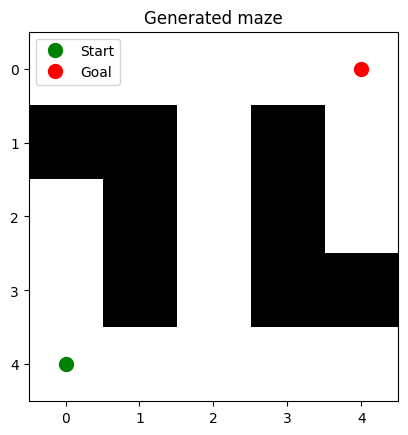

In [13]:
grid, random_maze_xml = generate_maze_xml()

# flips to have origin at bottom-left and goal top-right
im = (np.stack((grid.T[::-1, :],) * 3, axis=-1) * 255).astype(np.uint8)
plt.title("Generated maze")
plt.imshow(im)
plt.plot(0.0, 4.0, "go", markersize=10, label="Start")
plt.plot(4, 0, "ro", markersize=10, label="Goal")
plt.legend(loc="upper left")
plt.show()

!rm -rf scene_mjx_maze_flat_terrain.xml
f = open("scene_mjx_maze_flat_terrain.xml", "a")
f.write(random_maze_xml)
f.close()

### Initialize Simulation
Set up the MuJoCo simulation environment:
- Instantiate the `Go1Env` (which load the maze scene XML)
- Create a traversability map based the random generated maze
- Configure mujoco camera parameters and rendering options

In [14]:
# import mujoco after setting MUJOCO_GL to prevent errors in video rendering
import mujoco
from mujoco_playground._src import mjx_env
from typing import List

from src.environment.custom_go1_env import CustomGo1JoystickEnv
from src.environment.env_wrapper import Go1Env
from src.environment.traversability_map import TraversabilityMap, TraversabilityMapConfig
from src.control.controller_factory import ControllerFactory
from src.control.position_controller import PositionController, PositionControllerParams
from src.control.algorithms.mlp import MLPPolicy, MLPPolicyParams
from src.mission_executer import EpisodeResult, MissionConfig, MissionExecuter
from src.utils import load_yaml_with_jinja

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:44<00:00]


Checking out commit 14ceccf557cc47240202f2354d684eca58ff8de4
Successfully downloaded mujoco_menagerie


In [15]:
system_config = load_yaml_with_jinja("examples/configs/llm_navigation.yaml")
system_config

{'mission': {'goal': [4, 4],
  'max_sim_steps': 1000,
  'retry_delay_sec': 5,
  'max_attempts': 20},
 'control': {'position_controller': {'algorithm_type': 'position_controller',
   'command_dim': 3,
   'arrival_threshold': 0.1,
   'max_linear_velocity': 1.5,
   'max_angular_velocity': 1.57,
   'primary_controller': {'algorithm_type': 'seq_controller',
    'yaw_control_threshold': 0.175,
    'yaw_control_gain': 7.0,
    'linear_control_gain': 2.0},
   'fallback_controller': {'algorithm_type': 'seq_controller',
    'yaw_control_threshold': 0.175,
    'yaw_control_gain': 7.0,
    'linear_control_gain': 2.0}},
  'locomotion_controller': {'algorithm_type': 'mlp',
   'nn_num_layers': 4,
   'npy_path': 'src/control/nn_params/Go1JoystickFlatTerrain'}},
 'environment': {'mujoco_playground': {'name': 'Go1JoystickFlatTerrain',
   'random_key': 0},
  'map': {'grid_size': [5, 5], 'image_size': 50, 'threshold': 125}},
 'planning': {'llm_navigator': {'model_name': 'gemini-2.5-pro-exp-03-25'}}}

In [16]:
system_config["planning"]["llm_navigator"]["model_name"] = "gemini-2.5-pro-exp-03-25"

In [17]:
# instantiate mujoco Env
rng = jax.random.PRNGKey(system_config["environment"]["mujoco_playground"]["random_key"])
mpenv = CustomGo1JoystickEnv(xml_path="scene_mjx_maze_flat_terrain.xml")
env = Go1Env(env=mpenv, env_cfg=mpenv.env_cfg)

# create traversability map
trav_map_config = TraversabilityMapConfig.from_dict(system_config["environment"]["map"])
trav_map = TraversabilityMap(trav_map_config)
trav_map.load_from_grid(grid)  # or trav_map.load_grid("assets/floor1.jpg")

Downloaded: xmls/assets/calf.stl
Downloaded: xmls/assets/hip.stl
Downloaded: xmls/assets/thigh.stl
Downloaded: xmls/assets/thigh_mirror.stl
Downloaded: xmls/assets/trunk.stl


array([[1, 1, 1, 0, 1],
       [1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1],
       [1, 0, 1, 1, 1]], dtype=int32)

In [18]:
# Set up the camera
camera = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(camera)

# Object is centered at (0,0,1.5) with size 15m x 15m x 3m
camera.lookat[:] = np.array([2.0, 1.5, 1.5])  # Center of object

# Calculate distance using a safe margin
object_size = 6  # Maximum size in X or Y
fov = 45  # Default MuJoCo camera FOV
safe_margin = 1  # Factor to ensure entire object is in view

# Compute required distance using field of view
camera.distance = (object_size / 2) / np.tan(np.radians(fov / 2)) * safe_margin

# Look directly down
camera.azimuth = 90  # No horizontal rotation
camera.elevation = -70  # Near-directly downward

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

###  Define Helper Functions

In [19]:
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]


def sample_pert(rng, env, state):
    """
    Random purterbation to the robot
    """
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng


def update_position_history(position_history, current_position):
    # Only update position_history is the robot enters a new cell (by comparing position in integer)
    if len(position_history) == 0:
        position_history.append(current_position.astype(np.int32))
        return position_history
    if np.array_equal(position_history[-1].astype(np.int32), current_position.astype(np.int32)):
        return position_history
    else:
        position_history.append(current_position.astype(np.int32))
    return position_history


def run_one_episode(
    env: Go1Env,
    command_generator: PositionController,
    # instead of using base class Controller, we use subclass MLPPolicy as this method is very customized
    command_follower: MLPPolicy,
    traversability_map: TraversabilityMap,
    waypoints: List[np.ndarray],
    max_sim_steps: int,
    rng: jax.Array,
) -> EpisodeResult:
    rollout: List[mjx_env.State] = []
    position_history: List[np.ndarray] = []
    waypoint_idx: int = 0

    _, rng = jax.random.split(rng)
    state = env.reset(rng)

    # start closed-loop sim
    for i in tqdm(range(max_sim_steps)):
        _, rng = jax.random.split(rng)  # this will randomize perturbation
        rng = sample_pert(rng, env, state)

        # calculate control command
        cell_center_offset = 0.5
        target_position = waypoints[waypoint_idx] + cell_center_offset
        pos_command = command_generator.compute_command(state, target_position)
        state.info["command"] = pos_command.value

        ctrl = command_follower.control(state.obs["state"])  # controller step
        state = env.step(state, ctrl)  # simulator step

        # record
        rollout.append(state)
        position_history = update_position_history(position_history, pos_command.info.pos[:2])

        # check failure
        if not traversability_map.is_valid_position(pos_command.info.pos[:2]):
            return EpisodeResult(status="Stop", position_history=position_history, rollout=rollout)

        # check arrival at current waypoint
        if pos_command.info.is_arrived:
            waypoint_idx = min(waypoint_idx + 1, len(waypoints))  # proceed to next waypoint

            # Check if the arrived at the last waypoint
            if waypoint_idx == len(waypoints):
                return EpisodeResult(status="Success", position_history=position_history, rollout=rollout)

    return EpisodeResult(status="Timeout", position_history=position_history, rollout=rollout)

## Demo: Nagivating a go1 quadruped through a maze with Gemini-thinking Model
**The main navigation loop:**
1. Get waypoints from LLM planner
2. Execute waypoints using controllers
3. Provide feedback to LLM if attempt fails
4. Repeat until goal is reached or max attempts exceeded

The following picture illustrates the flowchart of the navigation task.
![](https://github.com/shaoanlu/llm_mjx_go1_playground/raw/main/assets/llm_go1_navigation.png)


### LLM Path Planner
A free tier Google API key is required to instantiate the `LLMNavigator` class. You can obtain one from [AU Studio](https://aistudio.google.com/app/apikey) with detailed instructions in [this docs](https://ai.google.dev/gemini-api/docs/api-key).

We use the LLM as the path planner:
- Takes the current state, the last failed attempts, and rendering of current simulation environment as inputs
- Outputs a sequence of waypoints for the robot to follow
- Adapts the plan based on feedback from failed attempts


Benifit of using additional image for conditioning: reduces the number of trials required before a successful attempt
- Despite a rendering of the simulation environment is provided, there are still some uncertainties e.g. the coordinate of the world and can only be calibrated through trial-and-error.

In [20]:
base_prompt = """
You are a path planner for a quadruped robot navigating in a partially known 5x5 grid environment.
Your task is to guide the robot from the start position around (0,0) to the goal position (4,4) as shown in the given image.

Environment specifications:
- Grid size: 5x5
- Start position: somewhere near (0,0) as the black robot shown in the image
- Goal position: (4,4), the red cell in the image
- There are walls in green that the robot can not pass through
- X-axis is the horizontal axis and Y-axis the vertical axis

Path planning constraints:
1. Maximum 10 waypoints allowed per path
2. Consecutive waypoints moving in the same direction must be simplified
   Example: [(0,0), (1,0), (2,0), (2,1)] should be simplified to [(0,0), (2,0), (2,1)]
3. Guess the wall positions from the image (especially leveraging the known goal position (4, 4) in red) and generate a path that avoids the robot hitting the wall
4. If previous result is provided, take it into account for calibrating your guesses about the coordinates

Expected output format:
Provide only a list of coordinates in the format (no other text should be generated such as ``` or ```python):
[(x0,y0), (x1,y1), ..., (xn,yn)]
"""

In [21]:
from google import genai
from google.colab import userdata
from src.planning.base import NavigationPlan, Planner
from src.planning.llm_nagivator import LLMNavigationPlan, _clean_instruction, _convert_to_list_of_numpy_arrays

from typing import List
from PIL import ImageFile

def get_simulation_img(state, camera=camera, scene_option=scene_option):
    frame = env.render(state, camera=camera, scene_option=scene_option, height=480, width=640)
    fn = "tmp.jpg"
    plt.imsave(fn, frame)
    return fn

class GeminiProVisionNavigator(Planner):
    def __init__(
        self,
        model_name: str = "gemini-2.5-pro-exp-03-25",
        prompt: str = "",
    ):
        self.model_name = model_name
        self.client = genai.Client(api_key=userdata.get("GOOGLE_API_KEY"))
        self.base_prompt = prompt

    def plan(self, prompt: str, image: ImageFile.ImageFile, **kwargs) -> List[np.ndarray]:
        """
        Args:
            prompt (str): a string that contains previous result
            image: a rendering of the current environment
        """
        response = self.client.models.generate_content(model="gemini-2.5-pro-exp-03-25", contents=[prompt + self.base_prompt, image])
        waypoints = eval(_clean_instruction(response.text))  # Convert string to list
        waypoints = _convert_to_list_of_numpy_arrays(waypoints)
        return self._create_navigation_plan(waypoints=waypoints, prompt=prompt)

    def _create_navigation_plan(self, waypoints: List[np.ndarray], prompt: str, **kwargs) -> NavigationPlan:
        return LLMNavigationPlan(waypoints=waypoints, trajectory=[], prompt=prompt)

llm_navigator = GeminiProVisionNavigator(prompt=base_prompt)

### Robot Controller
We use two levels of control:
1. High-level position controller that follows waypoints
2. Low-level MLP policy that controls individual joint movements

In [22]:
# Instantiate controller based on env_name
factory = ControllerFactory()
mlp_params = MLPPolicyParams.from_dict(system_config["control"]["locomotion_controller"])
command_follower = factory.build(params=mlp_params)

pc_config = PositionControllerParams.from_dict(system_config["control"]["position_controller"])
command_generator = PositionController(factory=factory, config=pc_config)

# Instantiate the ochestrator for mission execution
instruction = open("examples/prompt.txt", "r").read()
mission_config = MissionConfig.from_dict(system_config["mission"])
# mission_config.max_attempts = 20
# mission_config.max_sim_steps = 1000

### Create a partially applied function with fixed arguments for closed-loop simulation

In [23]:
from functools import partial

run_one_episode_func = partial(
    run_one_episode,
    env=env,
    command_generator=command_generator,
    command_follower=command_follower,
    traversability_map=trav_map,
)

## Start Navigation

I takes some time for the first simulation step as well as all Gemini-2.5 Pro inference (usually >=30s). During simulation, the intermediate reuslt of attemps will be printed out, including the prompt, the waypoints suggested by LLM, and the result.

In [47]:
!rm -rf sim_result
!mkdir sim_result

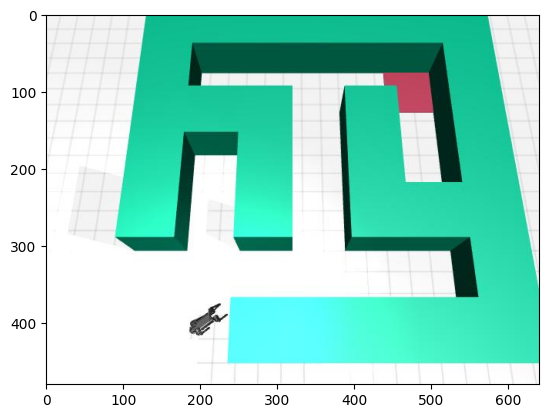

Calling Gemini API for planning... This might take a while.
prev_result_prompt=''
waypoints=[(0, 0), (0, 1), (2, 1), (2, 3), (4, 3), (4, 4)]
Start one episode of simulation


 18%|█▊        | 179/1000 [00:01<00:06, 117.84it/s]


[Trial 1]
result.status='Stop'
result.position_history=[array([0, 0], dtype=int32), array([0, 1], dtype=int32), array([1, 1], dtype=int32)]



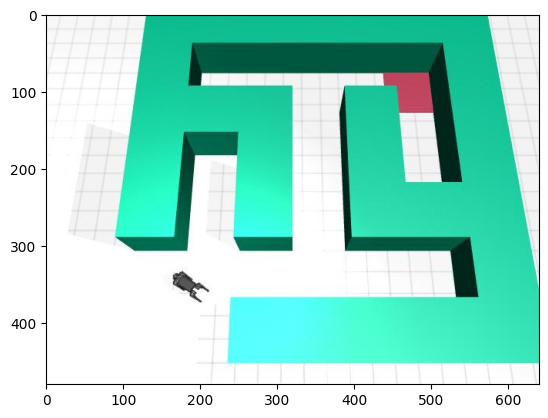

Calling Gemini API for planning... This might take a while.
prev_result_prompt='\nPrevious result: Failed: Stop at (1, 1), traversed cells: [(0, 0), (0, 1), (1, 1)]'
waypoints=[(0, 0), (0, 1), (1, 1), (4, 1), (4, 4)]
Start one episode of simulation


 22%|██▏       | 219/1000 [00:02<00:09, 83.54it/s]


[Trial 2]
result.status='Stop'
result.position_history=[array([0, 0], dtype=int32), array([0, 1], dtype=int32), array([1, 1], dtype=int32)]



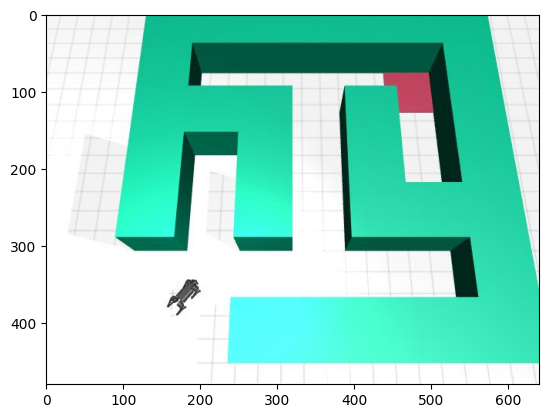

Calling Gemini API for planning... This might take a while.
prev_result_prompt='\nPrevious result: Failed: Stop at (1, 1), traversed cells: [(0, 0), (0, 1), (1, 1)]'
waypoints=[(0, 0), (4, 0), (4, 4)]
Start one episode of simulation


 31%|███       | 310/1000 [00:03<00:08, 86.19it/s] 


[Trial 3]
result.status='Stop'
result.position_history=[array([0, 0], dtype=int32), array([1, 0], dtype=int32), array([2, 0], dtype=int32), array([3, 0], dtype=int32), array([4, 0], dtype=int32), array([4, 1], dtype=int32)]



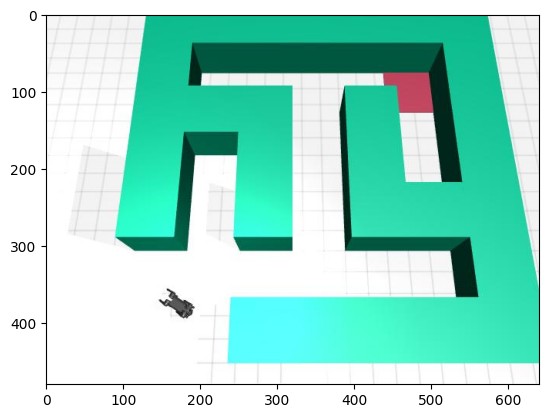

Calling Gemini API for planning... This might take a while.
prev_result_prompt='\nPrevious result: Failed: Stop at (4, 1), traversed cells: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1)]'
waypoints=[(0, 0), (2, 0), (2, 4), (4, 4)]
Start one episode of simulation


 53%|█████▎    | 528/1000 [00:04<00:03, 127.75it/s]

[Trial 4]
result.status='Success'
result.position_history=[array([0, 0], dtype=int32), array([1, 0], dtype=int32), array([2, 0], dtype=int32), array([2, 1], dtype=int32), array([2, 2], dtype=int32), array([2, 3], dtype=int32), array([2, 4], dtype=int32), array([3, 4], dtype=int32), array([4, 4], dtype=int32)]

Navigation completed.


In [48]:
import time
import PIL.Image

def format_failure_message(result: EpisodeResult) -> str:
    """Format failure message with position history."""
    x, y = result.position_history[-1].astype(int)
    return f"Failed: {result.status} at ({x}, {y}), traversed cells: {[tuple(np.round(x_, 1).tolist()) for x_ in result.position_history]}"


retry_delay_sec = 30
rollout_of_all_attempts = []
prev_result_prompt = ""

for attempt in range(mission_config.max_attempts):
    # Initialize for a new round of simulation and get the current rendering of the environment
    _, rng = jax.random.split(rng)
    state = env.reset(rng)  # duplicated reset as it is also called inside `run_one_episode_func`
    sim_img_path = get_simulation_img(state)
    sim_img = PIL.Image.open(sim_img_path)
    current_sim_img = plt.imread(sim_img_path)
    plt.imsave(f"sim_result/attempt{attempt}.jpg", current_sim_img)
    plt.imshow(current_sim_img)
    plt.show()

    # Prompt the LLM with env rendering to get waypoints suggestion
    print("Calling Gemini API for planning... This might take a while.")
    nav_plan: NavigationPlan = llm_navigator.plan(prompt=prev_result_prompt, image=sim_img)
    waypoints = list(nav_plan.waypoints)
    print(f"{prev_result_prompt=}")
    print(f"Planned waypoints are: {[tuple(np.round(x_, 1).tolist()) for x_ in waypoints]}")

    # run the mission (simulation)
    result: EpisodeResult = run_one_episode_func(
        waypoints=waypoints,
        max_sim_steps=mission_config.max_sim_steps,
        rng=rng,
    )
    rollout_of_all_attempts.extend(result.rollout)

    print(f"\n[Trial {attempt + 1}]\n{result.status=}\n{result.position_history=}\n")

    if result.status == "Success":
        print("Navigation completed.")
        break
    else:
        prev_result_prompt = f"\nPrevious result: {format_failure_message(result)}"

    # add a delay before retrying to avoid API rate limiting
    time.sleep(retry_delay_sec)


## Results Visualization

### Render Navigation Video
Visualize the successful navigation attempt:
- Shows the robot's movement through the maze
- Includes fog of war effect to highlight explored areas
- Demonstrates how the robot avoids discovered obstacles

In [53]:
render_every = 10
fps = 3.0 / env.dt / render_every  # 3x realtime
traj = rollout_of_all_attempts[::render_every]

frames = env.render(traj, camera=camera, scene_option=scene_option, height=480, width=640)

100%|██████████| 248/248 [04:54<00:00,  1.19s/it]


In [ ]:
mediapy.show_video(frames, fps=fps, loop=False)

array([[[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       [[232, 232, 232],
        [232, 232, 232],
        [232, 232, 232],
        ...,
        [229, 229, 229],
        [229, 229, 229],
        [229, 229, 229]],

       [[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [236, 236, 236],
        [236, 236, 236],
        [236, 236, 236]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [245, 245, 245],
        [250, 250, 250],
        [251, 251, 251]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [239, 239, 239],
        [250, 250, 250],
        [251, 251, 251]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [234, 234, 234],
        [249, 249, 249],
        [251, 251, 251]]], dtype=uint8)
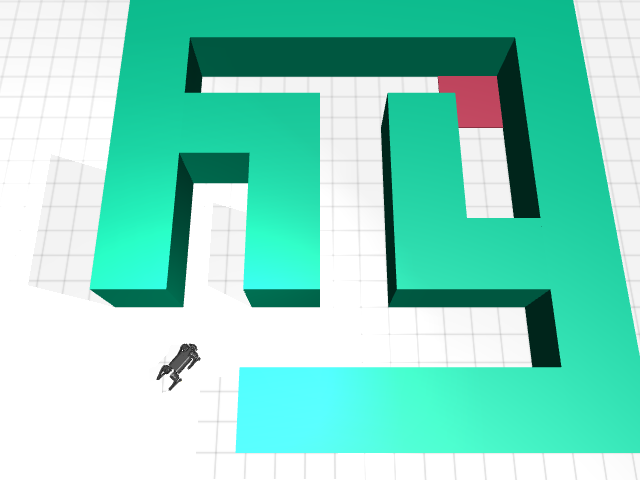

In [52]:
frames[0]